In [1]:
##===================
# Installing required packages:
##===================

# - pandas for dataframes 
# - numpy for numerical computing
# - matplotlib for making graphs
# - seaborn for more complex graphs, complementary to matplotlib
# - scipy for statistical analysis
#
# For our ML models: 
# - sklearn.model_selection to split data to train and split
# - sklearn.linear_model to build a linear model
# - sklearn.metrics for evaluating the model
# - sklearn.preprocessing for making the polynomial model, and feature scaling
# - sklearn.svm for support vector regression
#
# For calculating time in python:
# - time


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sma
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.svm import SVR

import time


# Step 1: Collect Data

In [2]:
t01 = time.time() #For calculating how much time this need to run
daily_activity = pd.read_csv(r"..\Data\dailyActivity_merged.csv")
daily_calories = pd.read_csv(r"..\Data\dailyCalories_merged.csv")
daily_steps = pd.read_csv(r"..\Data\dailySteps_merged.csv")
hourly_calories = pd.read_csv(r"..\Data\hourlyCalories_merged.csv")
hourly_intensities = pd.read_csv(r"..\Data\hourlyIntensities_merged.csv")
hourly_steps = pd.read_csv(r"..\Data\hourlySteps_merged.csv")
min_calories_n = pd.read_csv(r"..\Data\minuteCaloriesNarrow_merged.csv")
min_steps_n = pd.read_csv(r"..\Data\minuteStepsNarrow_merged.csv")
sec_heartrate = pd.read_csv(r"..\Data\heartrate_seconds_merged.csv")
weight = pd.read_csv(r"..\Data\weightLogInfo_merged.csv")

# Step 2: Inspect Data

In [4]:
#example is for weight, but can be for any of the dataframes used 
dataset = weight
print ("Data Preview: \n", dataset.head())# Top 10 lines of the df
#list(dataset)  # Columns of the df
print ("----")
print (" ")

#len(dataset)   # No of rows
print ("Dimensions of data (rows,columns): \n", dataset.shape)  # Dimensions of df
print ("----")
print (" ")

print ("Column datatypes: \n", dataset.dtypes) # Datatype of each column
print ("----")

print (" ")
print ("Class of object in each column *10th line")
for i in range (dataset.shape[1]):
    print (dataset.columns[i], 'is' ,type(dataset.iloc[:,i][10])) #returns the type of object in each column
                                               #type of the 14th line for each column
print ("----")
print (" ")
print ("Null Values per Column: \n", dataset.isnull().sum())
 # shows how many null values are in each colunm
print ("----")
print (" ")
print ('Unique Values Per Column:\n',dataset.nunique())
 # shows no of unique values for a specific column:
print ("----")
index = 0 #index of column for which unique values will be counted 
print ('No of entries for unique values in column',dataset.columns[index],':\n',(dataset.iloc[:,index]).value_counts())

Data Preview: 
            Id                   Date    WeightKg  WeightPounds   Fat  \
0  1503960366   5/2/2016 11:59:59 PM   52.599998    115.963147  22.0   
1  1503960366   5/3/2016 11:59:59 PM   52.599998    115.963147   NaN   
2  1927972279   4/13/2016 1:08:52 AM  133.500000    294.317120   NaN   
3  2873212765  4/21/2016 11:59:59 PM   56.700001    125.002104   NaN   
4  2873212765  5/12/2016 11:59:59 PM   57.299999    126.324875   NaN   

         BMI  IsManualReport          LogId  
0  22.650000            True  1462233599000  
1  22.650000            True  1462319999000  
2  47.540001           False  1460509732000  
3  21.450001            True  1461283199000  
4  21.690001            True  1463097599000  
----
 
Dimensions of data (rows,columns): 
 (67, 8)
----
 
Column datatypes: 
 Id                  int64
Date               object
WeightKg          float64
WeightPounds      float64
Fat               float64
BMI               float64
IsManualReport       bool
LogId         

In [4]:
daily_steps

,Id,ActivityDay,StepTotal
0,1503960366,4/12/2016,13162
1,1503960366,4/13/2016,10735
2,1503960366,4/14/2016,10460
3,1503960366,4/15/2016,9762
4,1503960366,4/16/2016,12669
...,...,...,...
935,8877689391,5/8/2016,10686
936,8877689391,5/9/2016,20226
937,8877689391,5/10/2016,10733
938,8877689391,5/11/2016,21420


In [5]:
sec_heartrate

,Id,Time,Value
0,2022484408,4/12/2016 7:21:00 AM,97
1,2022484408,4/12/2016 7:21:05 AM,102
2,2022484408,4/12/2016 7:21:10 AM,105
3,2022484408,4/12/2016 7:21:20 AM,103
4,2022484408,4/12/2016 7:21:25 AM,101
...,...,...,...
2483653,8877689391,5/12/2016 2:43:53 PM,57
2483654,8877689391,5/12/2016 2:43:58 PM,56
2483655,8877689391,5/12/2016 2:44:03 PM,55
2483656,8877689391,5/12/2016 2:44:18 PM,55


# Step 3: Data mining

In [6]:
###
#Aggregating heartrate data (per 5 seconds) to per minute for comparison with other dataframes
###
t1 = time.time()
print((time.time()-t1)/60,0)

#renaming the Time column to DateTime
sec_heartrate.rename(columns = {'Time':'DateTime'}, inplace = True)

print((time.time()-t1)/60,1)

# Extracting the date from the DateTime
sec_heartrate['Date'] = pd.to_datetime(sec_heartrate.DateTime).dt.date

print ((time.time()-t1)/60,2)

# Extracting the time from the Datetime
sec_heartrate['Time'] = pd.to_datetime(sec_heartrate.DateTime).dt.time

print ((time.time()-t1)/60,3)

# Extracting the Hour and the Minute to help in aggregating by minute
sec_heartrate['Hour'] = pd.to_datetime(sec_heartrate.Time.astype(str)).dt.hour
sec_heartrate['Min'] = pd.to_datetime(sec_heartrate.DateTime.astype(str)).dt.minute

print ((time.time()-t1)/60,4)


#Aggregating heartrate data to per minute:

#Grouping to make a df of heartrates by minute, calculating the mean heartrate per minute
min_heartrate = sec_heartrate.groupby(['Id','Date','Hour','Min']).mean().reset_index()

print ((time.time()-t1)/60,5)

# changing the minute to the true value of the grouping (00:02:05 belongs to the 3rd minute)
min_heartrate['Min'] = min_heartrate['Min']-1 

print ((time.time()-t1)/60,6)

# correcting the -1 value to the 59thn minute of the hour
min_heartrate['Min'].mask(min_heartrate['Min']== -1,59,inplace=True) 

print ((time.time()-t1)/60,7)

# adding a time column to join with other dfs
min_heartrate['Time'] = (pd.to_datetime(min_heartrate['Hour'].astype(str) + ':' + min_heartrate['Min'].astype(str), format='%H:%M').dt.time)

print ((time.time()-t1)/60,8)

# removing Hour and Min features
min_heartrate.drop(['Hour', 'Min'], axis=1, inplace=True)

print ((time.time()-t1)/60,9)

#renaming the Value column to Heartbeat
min_heartrate.rename(columns = {'Value':'Heartbeat'}, inplace = True)

print('Took',(time.time()-t1)/60,'min') #estimating time needed for this to run

0.0 0
0.00014830430348714192 1
10.804163642724355 2
18.257494016488394 3
26.811224687099457 4
26.9060933192571 5
26.910424558321633 6
26.915208129088082 7
26.940984392166136 8
26.941520210107168 9
Took 26.941601924101512 min


In [7]:
###
#Setting up python timer to evaluate how long (in min) every step takes
###
t1 = time.time()
print((time.time()-t1)/60,0)

###
# Adding Date and Hour in min_calories_n df: 
###
min_calories_n['Date']=pd.to_datetime(min_calories_n['ActivityMinute']).dt.date
print((time.time()-t1)/60,1)
min_calories_n['Time']=pd.to_datetime(min_calories_n['ActivityMinute']).dt.time
print((time.time()-t1)/60,2)

###
# Adding Date and Hour in min_steps_n df: 
###
min_steps_n['Date']=pd.to_datetime(min_steps_n['ActivityMinute']).dt.date
print((time.time()-t1)/60,3)
min_steps_n['Time']=pd.to_datetime(min_steps_n['ActivityMinute']).dt.time
print((time.time()-t1)/60,4)

###
#Removing the ActivityMinute feature:
###
min_calories_n.drop(['ActivityMinute'], axis=1, inplace=True)
print((time.time()-t1)/60,5)

min_steps_n.drop(['ActivityMinute'], axis=1, inplace=True)
print('Took',(time.time()-t1)/60,'min')



0
0.0 1
3.28360622326533 1
6.3811766346295675 2
9.21255921125412 3
12.138808647791544 4
12.145528280735016 5
Took 12.149466880162556 min


# Step 4: Combine usefull data to a single df

In [14]:
###
#Merging data into one df
###
by_min = pd.merge(min_calories_n, min_steps_n, on=['Id','Date','Time'], how ="inner")
by_min = pd.merge(by_min, min_heartrate, on=['Id','Date','Time'], how ="inner")

###
#Filtering out datapoints with steps <10, and Calories <2.5
###
by_min = by_min.loc[(by_min.Steps > 10)&
               (by_min.Calories >=2.5)]
by_min.reset_index(inplace = True, drop = True)

# Step 5: Checking for dependencies
## (i) For all the Users together
### a) Matrix of scatter plots: 

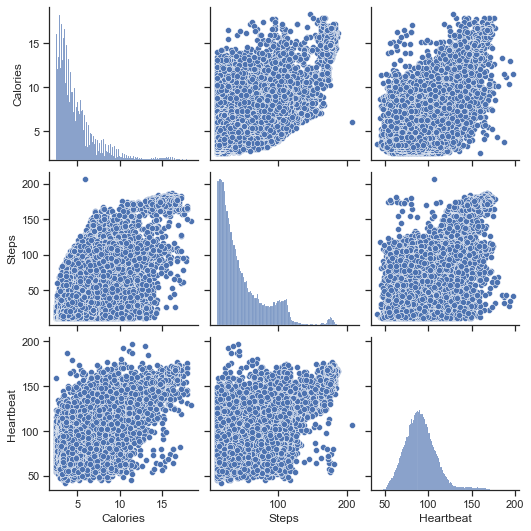

In [398]:
sns.set_theme(style="ticks")
sns.pairplot(by_min.iloc[:, [1,4,5]])
#sns.pairplot(by_min, hue="Id") #separates per user

#### Conclusion:
    We can see that there is no simple linear regression between any of the features of our data. However, in case the data change in the future, we also calculate the correlation coefficeints for future use.

### b)  Pairwise correlation of all columns
        - Calculating the Pearson and Spearmant correlation coefficients between the features

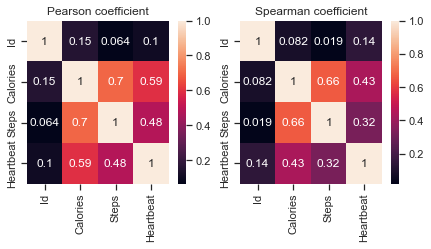

In [399]:
###
#Side by side heatmap with Pearson and Spearman coefficients
###
fig, ax =plt.subplots(1,2)

sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(by_min.corr('pearson'),annot=True, ax=ax[0]) 
sns.heatmap(by_min.corr('spearman'),annot=True, ax=ax[1])
ax[0].set_title("Pearson coefficient")
ax[1].set_title("Spearman coefficient")

plt.show()

#### Conclusion:
   
 From Pearson coefficient:
 - There is a **Strong correlation** (0.7) between **Calories** and **Steps**
 - There is a Moderate correlation (0.59) between Calories and Heartrate
 - There is a Moderate correlation (0.48) between Heartbeat and Steps

From Spearman coefficient:
 - There is a Moderate correlation (0.66) between **Calories** and **Steps**
 - There is a Moderate correlation (0.43) between Calories and Heartrate
 - There is a Weak correlation (0.32) between Heartbeat and Steps
  

## (ii) Checking for dependencies for each individual

##### Before running the analysis on each user separately, we focus our analysis on two random users

### 1) Matrix of scatter plots:

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


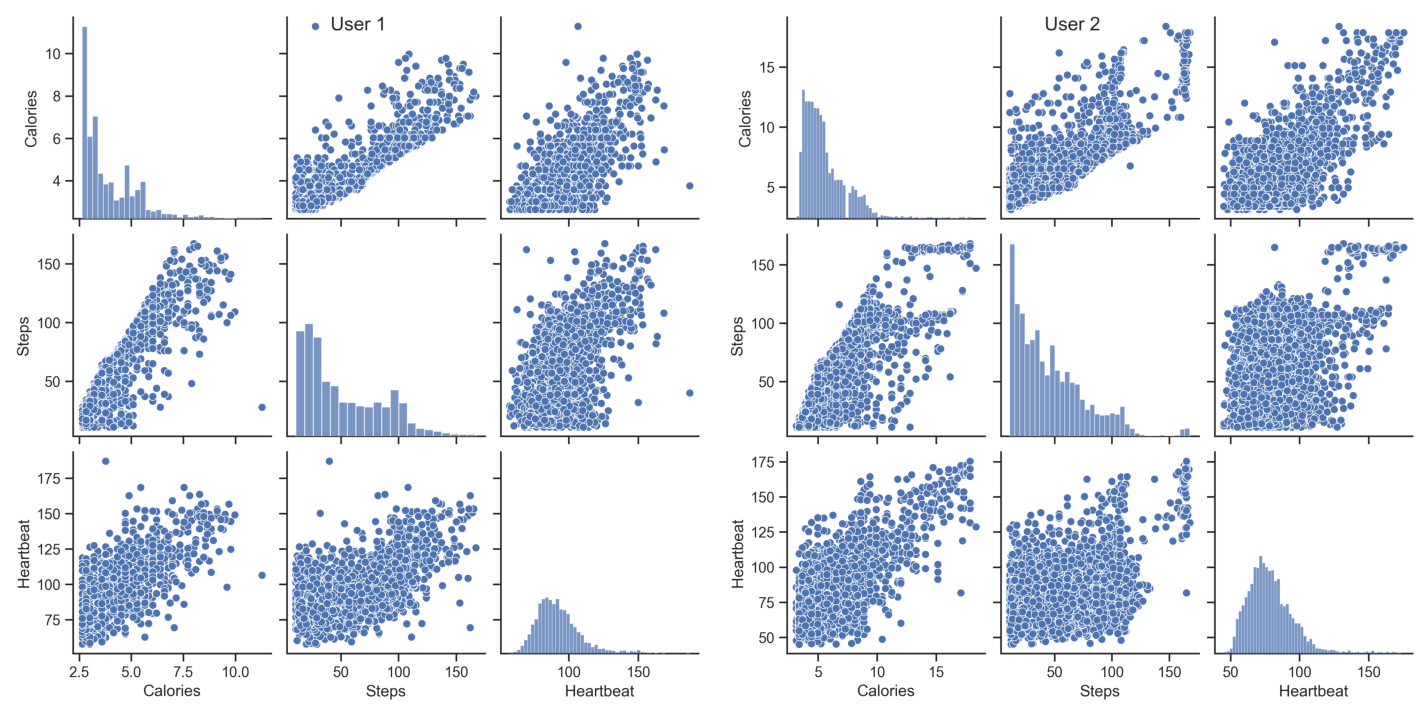

In [396]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def pairplot(df):

    sns.set(style="ticks")
    return sns.pairplot(df) # !!! I've placed a return

df1 = by_min.loc[by_min.Id == by_min.Id.unique()[2]]
df2 = by_min.loc[by_min.Id == by_min.Id.unique()[4]]

df1.drop(['Id'], axis=1, inplace=True)
df2.drop(['Id'], axis=1, inplace=True)



g0 = pairplot(df1)
g0.fig.suptitle("User 1")
g1 = pairplot(df2)
g1.fig.suptitle("User 2")



############### 1. SAVE PLOTS IN MEMORY TEMPORALLY
g0.savefig('g0.png', dpi=300)
plt.close(g0.fig)

g1.savefig('g1.png', dpi=300)
plt.close(g1.fig)


############### 2. CREATE SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(1, 2, figsize=(20, 20))

axarr[0].imshow(mpimg.imread('g0.png'))
axarr[1].imshow(mpimg.imread('g1.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.savefig("ScatterPlot")
plt.show()

### There could be different correlation-relations for different users

|Feature-pairs       | User 1           | User 2          |
|--------------------|------------------|--------|
| Calories-Heartbeat | Correlation      | Correlation    |
| Calories-Steps     | Correlation      | Correlation   |
| Steps-Heartbeat    | **Correlation**  | **No Correlation** |


### 2)  Pairwise correlation of all columns
        - Calculating the Pearson and Spearman correlation coefficients between the different features

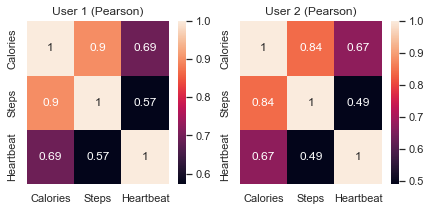

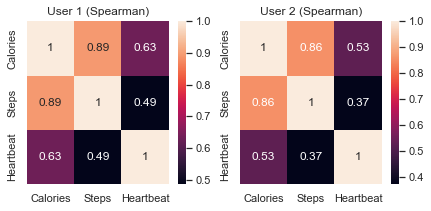

In [46]:
###
#Side by side heatmap with Pearson coefficients for the two users
###
sns.set(rc = {'figure.figsize':(7,3)})
fig, ax =plt.subplots(1,2)

sns.heatmap(df1.corr('pearson'),annot=True, ax=ax[0]) 
sns.heatmap(df2.corr('pearson'),annot=True, ax=ax[1])
ax[0].set_title("User 1 (Pearson)")
ax[1].set_title("User 2 (Pearson)")

plt.show()

###
#Side by side heatmap with Spearman coefficients for the two users
###
sns.set(rc = {'figure.figsize':(7,3)})
fig, ax =plt.subplots(1,2)

sns.heatmap(df1.corr('spearman'),annot=True, ax=ax[0]) 
sns.heatmap(df2.corr('spearman'),annot=True, ax=ax[1])
ax[0].set_title("User 1 (Spearman)")
ax[1].set_title("User 2 (Spearman)")

plt.show()

### There is a strong correlation between Calories and Steps, for both users, and  a moderate correlation between Calories and Heartbeat


In [358]:
###
#Calculating the p-value for all the possible features (for borth users)
###


#list of features we are interested
feat = ['Calories','Steps','Heartbeat']

# Creating an empty df to fill with p-values between features
p_list = pd.DataFrame()
p_user1 = []
p_user2 = []
p_list["Feat1"] = [feat[0],feat[1],feat[2]]
p_list["Feat2"] = [feat[1],feat[2],feat[0]]


#Choosing the dfs for two users
df1 = by_min.loc[by_min.Id == by_min.Id.unique()[2]]
df2 = by_min.loc[by_min.Id == by_min.Id.unique()[4]]
df1.drop(['Id'], axis=1, inplace=True)
df2.drop(['Id'], axis=1, inplace=True)


#list of dfs for each user
p_user1.append(stats.linregress(df1['Calories'],df1['Steps'])[3])
p_user1.append(stats.linregress(df1['Steps'],df1['Heartbeat'])[3])
p_user1.append(stats.linregress(df1['Heartbeat'],df1['Calories'])[3])


p_user2.append(stats.linregress(df2['Calories'],df2['Steps'])[3])
p_user2.append(stats.linregress(df2['Steps'],df2['Heartbeat'])[3])
p_user2.append(stats.linregress(df2['Heartbeat'],df2['Calories'])[3])


p_list['User1_p-value'] = p_user1
p_list['User2_p-value'] = p_user2

print ("p-value for users 1 and 2:")
display(p_list)


p-value for users 1 and 2:


c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Feat1,Feat2,User1_p-value,User2_p-value
0,Calories,Steps,0.000000e+00,0.0
1,Steps,Heartbeat,9.436756e-262,0.0
2,Heartbeat,Calories,0.000000e+00,0.0


### From Pearson coefficient, Spearman coefficient and p-value, we conclude that Calories depend both from Steps and Heartbeat.   

# Further Analysis:
## We focus on linear regression modeling

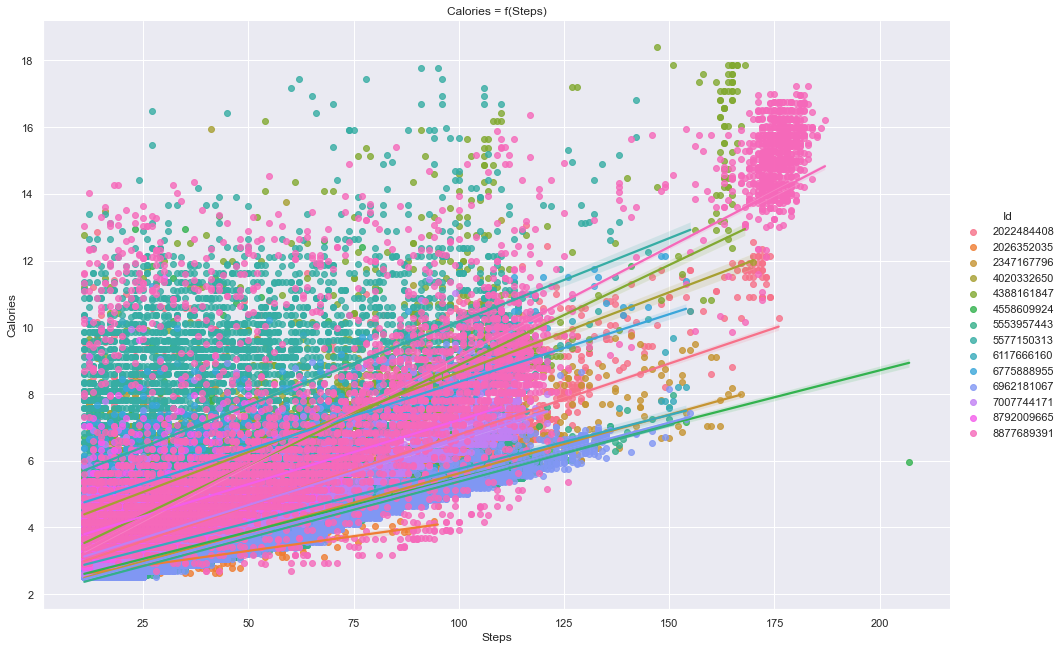

In [219]:
###
#General view of linear regression of Callories with relation to Steps
###

sns.set_theme()
###
#users with steps > 10 per min and calories >= 2.5 
###
df = by_min.loc[(by_min.Steps > 10)&
               (by_min.Calories >=2.5)]
g = sns.lmplot(
    data=df,
    x="Steps", y="Calories", hue="Id",
    height=9, aspect=1.5
)
g.set_axis_labels("Steps", "Calories")

ax = plt.gca()
ax.set_title("Calories = f(Steps)")
plt.show()

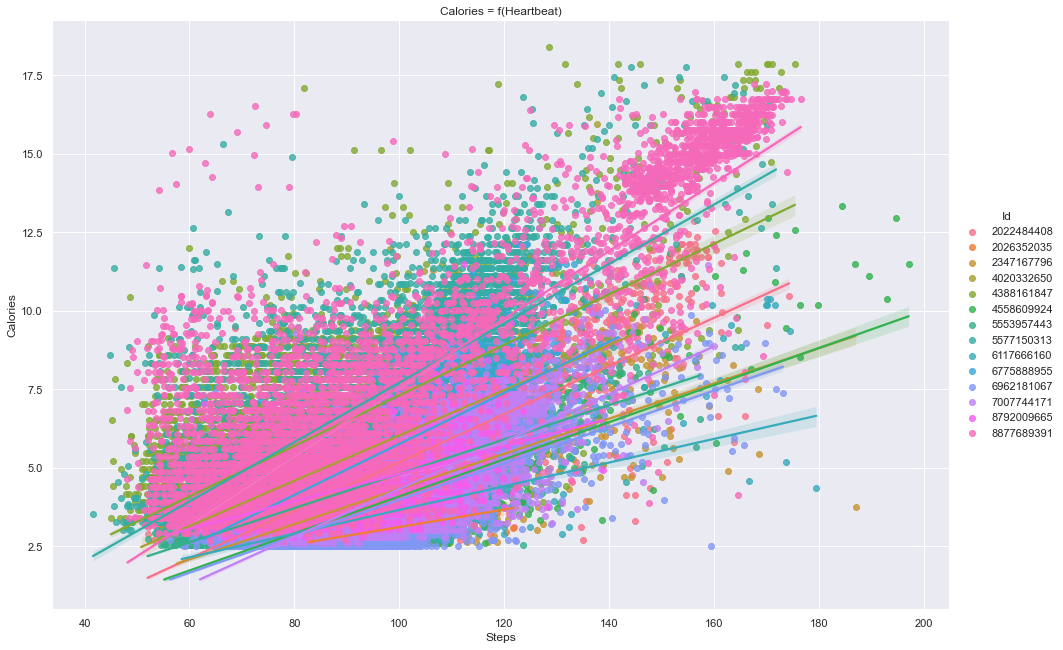

In [220]:
###
#General view of linear regression of Callories with relation to Heartrate
###

sns.set_theme()

df = by_min.loc[(by_min.Steps > 10)&
               (by_min.Calories >=2.5)]

g = sns.lmplot(
    data=df,
    x="Value", y="Calories", hue="Id",
    height=9, aspect=1.5
)

g.set_axis_labels("Steps", "Calories")

ax = plt.gca()
ax.set_title("Calories = f(Heartrate)")
plt.show()

## Next we take a single case and analyze it in detail:
    - Make a Simple Linear Regression (SLR) model for calories compared to Steps
    - Make a Simple Linear Regression (SLR) model for calories compared to Heartrate
    - Make a Multi Linear Regression (MLR) model for calories compared to both Heartrate and Steps
    - Compare them unsing the R-squared value

# Simple Linear Regression

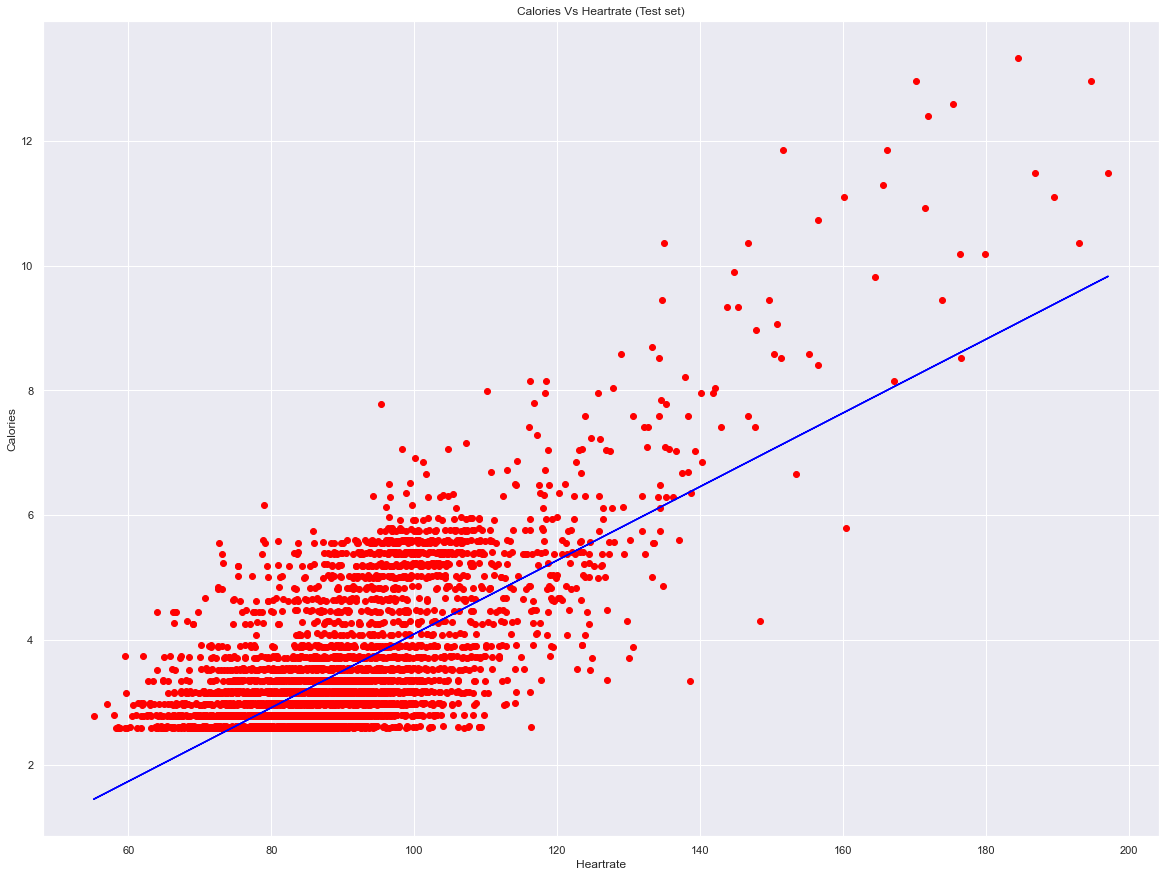

Slope: 0.059058629448866376
Intercept -1.813183634151459
Rsquare = 0.5016194607163251
p-value = 0.0


In [436]:
###
#Defining dataset
###
df = by_min.loc[(by_min.Steps > 10)&
               (by_min.Calories >=2.5)&
                ((by_min.Id == by_min.Id[23456]))]
X = df.iloc[:, -1].values.reshape(-1, 1)
y = df.iloc[:, 1].values


###
#Splitting the dataset into the Training set and Test set
###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

###
#Training the Simple Linear Regression model on the training set
###
regressor = LinearRegression()
regressor.fit(X_train, y_train)

###
#Training the Simple Linear Regression model on the whole dataset
###
lin_reg = LinearRegression() # create the model (the object)
lin_reg.fit(X,y) #train the model


# ###
# #Predicting the Test set results
# ###
# y_pred = regressor.predict(X_test)

# ###
# #Visualisigin the Training set results:
# ###
# plt.scatter(X_train, y_train, color = 'red')
# plt.plot(X_train, regressor.predict(X_train), color = 'blue')
# plt.title('Calories Vs Heartrate (Training set)')
# plt.xlabel('Heartrate')
# plt.ylabel('Calories')
# plt.show()


# ###
# #Visualisigin the Test set results:
# ###
# plt.scatter(X_test, y_test, color = 'red')
# plt.plot(X_train, regressor.predict(X_train), color = 'blue')
# plt.title('Calories Vs Heartrate (Test set)')
# plt.xlabel('Heartrate')
# plt.ylabel('Calories')
# plt.show()

###
#Visualisigin the Linear regression result of the full dataset fit:
###
plt.scatter(X,y, color = 'red')
plt.plot(X,lin_reg.predict(X), color = 'blue')
plt.title('Calories Vs Heartrate (Test set)')
plt.xlabel('Heartrate')
plt.ylabel('Calories')
plt.show()

###
#Getting the final linear regression equation with the values of the coefficients
###
#y = b0 + b1*x


print('Slope:',lin_reg.coef_[0]) #b1
print('Intercept',lin_reg.intercept_) #b0

rsq = r2_score(y, lin_reg.predict(X))
print ("Rsquare =",rsq)


##
#transforming the X_train to a format necessary for calculating the p_value
##
xtrain = []
for i in range (len(X_train)):
    xtrain.append(X_train[i][0])


x = []
for i in range (len(X)):
    x.append(X[i][0])

    
p_value = stats.linregress(x,y)[3]
print ("p-value =",p_value)


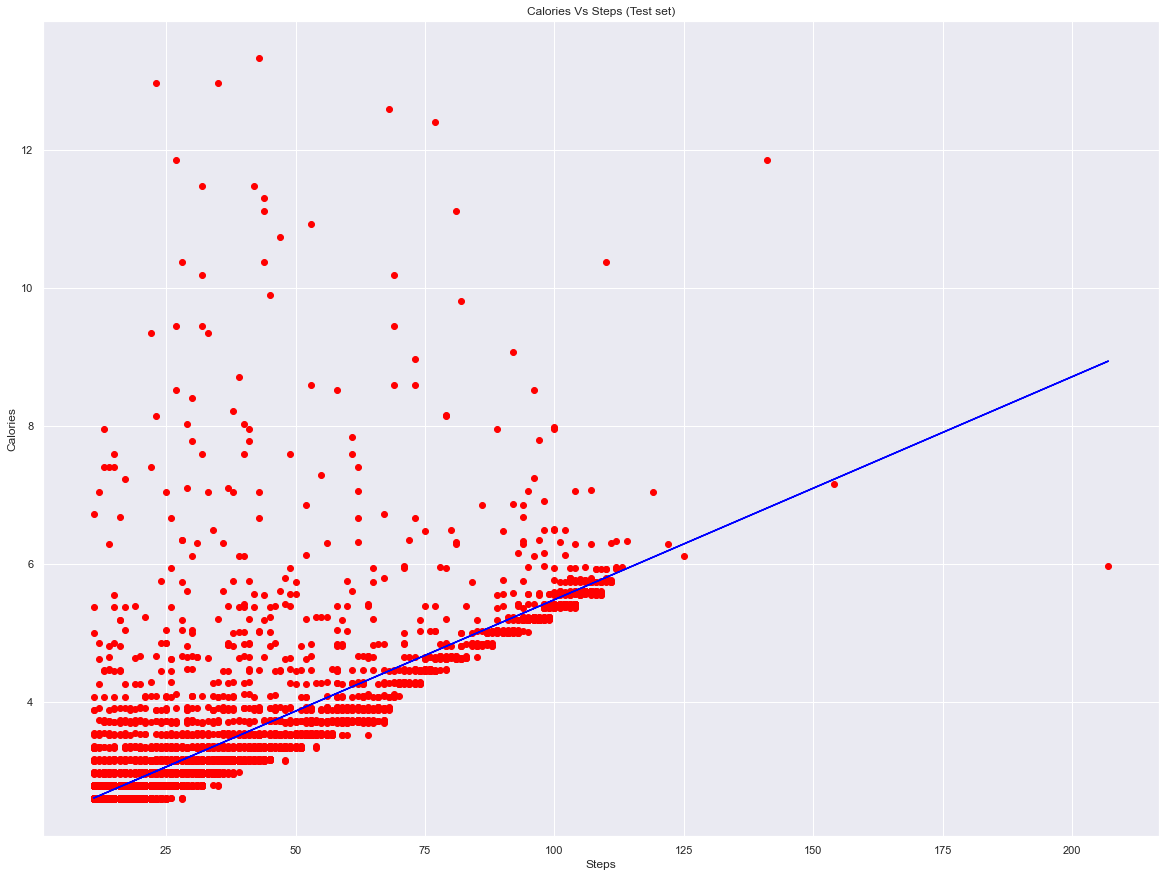

Slope: 0.03228841251862605
Intercept 2.252588249949026
Rsquare = 0.5429951449112032
p-value = 0.0


In [437]:
###
#Defining dataset
###
df = by_min.loc[(by_min.Steps > 10)&
               (by_min.Calories >=2.5)&
                (by_min.Id == by_min.Id[23456])
               ]
X = df.iloc[:, -2].values.reshape(-1, 1)
y = df.iloc[:, 1].values


###
#Splitting the dataset into the Training set and Test set
###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

###
#Training the Simple Linear Regression model on the Training set
###
regressor = LinearRegression()
regressor.fit(X_train, y_train)

###
#Training the Simple Linear Regression model on the whole dataset
###
lin_reg = LinearRegression() # create the model (the object)
lin_reg.fit(X,y) #train the model


# ###
# #Predicting the Test set results
# ###
# y_pred = regressor.predict(X_test)

# ###
# #Visualisigin the Training set results:
# ###
# plt.scatter(X_train, y_train, color = 'red')
# plt.plot(X_train, regressor.predict(X_train), color = 'blue')
# plt.title('Calories Vs Heartrate (Training set)')
# plt.xlabel('Heartrate')
# plt.ylabel('Calories')
# plt.show()


# ###
# #Visualisigin the Test set results:
# ###
# plt.scatter(X_test, y_test, color = 'red')
# plt.plot(X_train, regressor.predict(X_train), color = 'blue')
# plt.title('Calories Vs Heartrate (Test set)')
# plt.xlabel('Heartrate')
# plt.ylabel('Calories')
# plt.show()

###
#Visualisigin the Linear regression result of the full dataset fit:
###
plt.scatter(X,y, color = 'red')
plt.plot(X,lin_reg.predict(X), color = 'blue')
plt.title('Calories Vs Steps (Test set)')
plt.xlabel('Steps')
plt.ylabel('Calories')
plt.show()

###
#Getting the final linear regression equation with the values of the coefficients
###
#y = b0 + b1*x


print('Slope:',lin_reg.coef_[0]) #b1
print('Intercept',lin_reg.intercept_) #b0

rsq = r2_score(y, lin_reg.predict(X))
print ("Rsquare =",rsq)


##
#transforming the X_train to a format necessary for calculating the p_value
##
xtrain = []
for i in range (len(X_train)):
    xtrain.append(X_train[i][0])


x = []
for i in range (len(X)):
    x.append(X[i][0])

    
p_value = stats.linregress(x,y)[3]
print ("p-value =",p_value)


# Multilinear regression

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


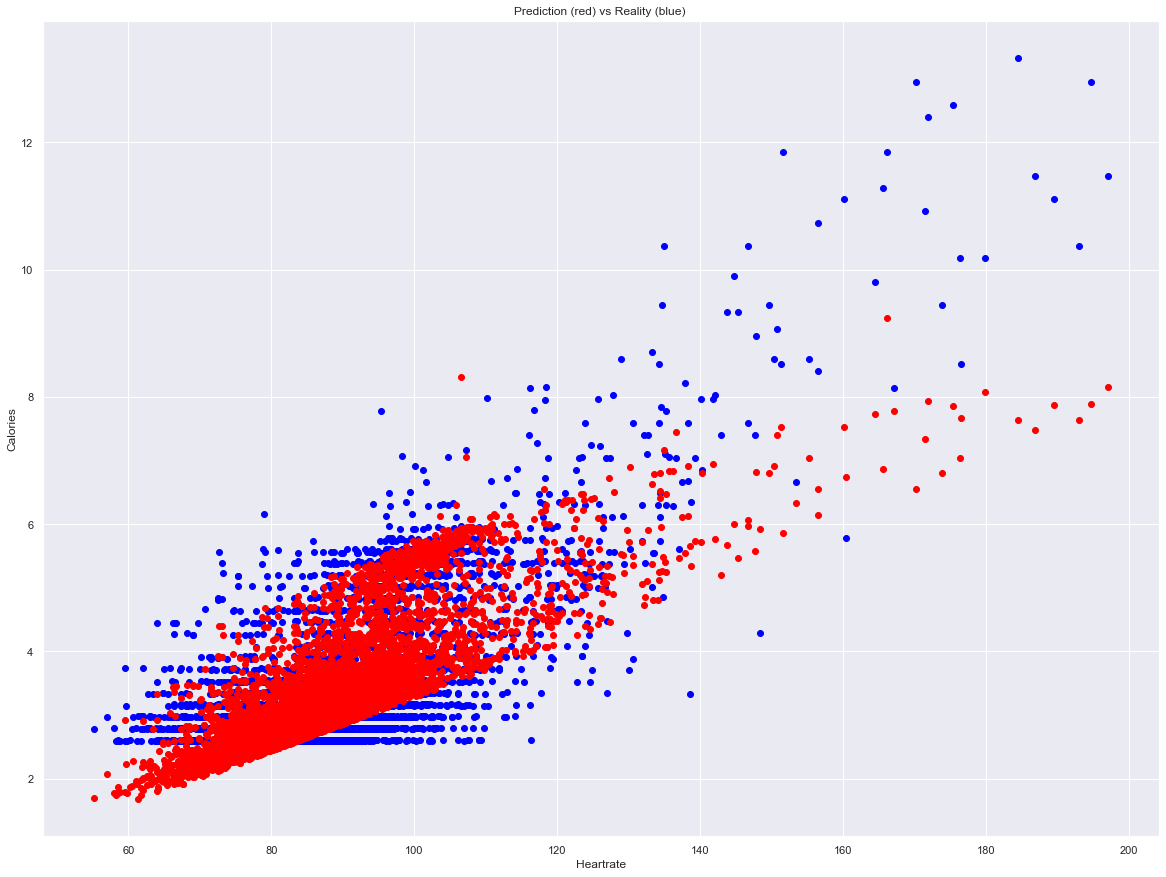

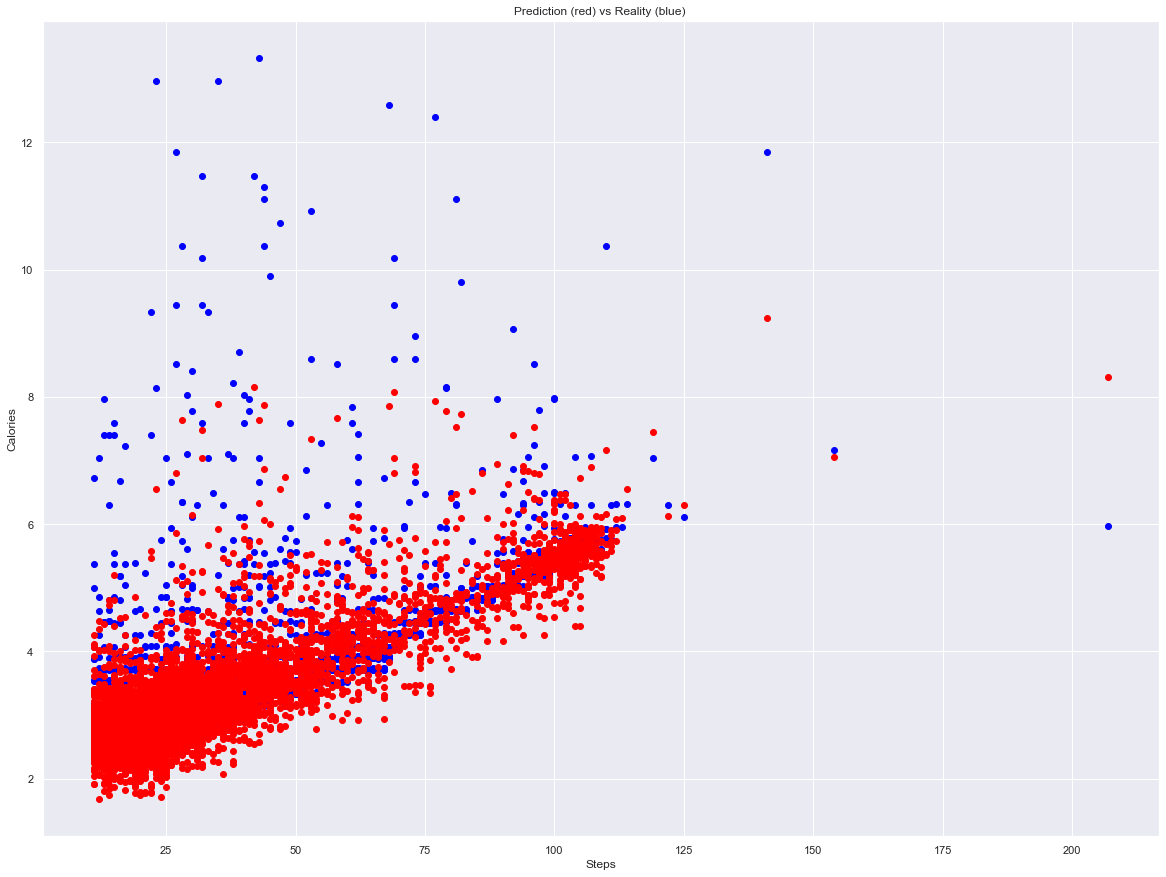

Step Slope: 0.02422346413543674
HR Slope: 0.0423539062638164
Intercept: -1.2138360445849266
Rsq: 0.7671031627580807


In [439]:
###
#Multilinear regression for a single user:
###


#Transforming our dataset for using it in our ML:
#choosing 1 user:
dataset = by_min.loc[(by_min.Id == by_min.Id[23456])&
                    (by_min.Steps > 10)&
                    (by_min.Calories >= 2.5)]



#deleting all non_dependent variables:
dataset.drop(['Id','Date','Time'], axis=1, inplace=True)

###
#Importing the dataset
###
X = dataset.iloc[:, 1:3].values
y = dataset.iloc[:, 0].values

###
#Splitting training-test set
###
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

###
#Training the Multiple Linear Regression model on the Training set
###
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)

###
#Training the Multiple Linear Regression model on the Full dataset set
###
from sklearn.linear_model import LinearRegression
multi_regressor = LinearRegression()
multi_regressor.fit(X,y)

###
#Making the Calorie prediction:
###
y_fullpred = multi_regressor.predict(X)

###
#Comparing prediction with real values:
###
np.set_printoptions(precision = 2)
#print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

# ###
# #Visualizing prediction Vs Reality on Calories = f(Heartrate) :
# ###
# plt.scatter(X_test[:,1], y_test, color = 'blue') #X_test[:,3] is one of the variables that I chose to show the Visualization
# plt.scatter(X_test[:,1], y_pred, color = 'red')
# plt.title('Prediction (red) vs Reality (blue) ')
# plt.xlabel('Heartrate')
# plt.ylabel('Calories')
# plt.show()

# ###
# #Visualizing prediction Vs Reality on Calories = f(Steps) :
# ###
# plt.scatter(X_test[:,0], y_test, color = 'blue') #X_test[:,3] is one of the variables that I chose to show the Visualization
# plt.scatter(X_test[:,0], y_pred, color = 'red')
# plt.title('Prediction (red) vs Reality (blue) ')
# plt.xlabel('Steps')
# plt.ylabel('Calories')
# plt.show()


###
#Visualizing prediction Vs Reality on Calories = f(Heartrate) :
###
plt.scatter(X[:,1], y, color = 'blue') #X_test[:,3] is one of the variables that I chose to show the Visualization
plt.scatter(X[:,1], y_fullpred, color = 'red')
plt.title('Prediction (red) vs Reality (blue) ')
plt.xlabel('Heartrate')
plt.ylabel('Calories')
plt.show()

###
#Visualizing prediction Vs Reality on Calories = f(Steps) :
###
plt.scatter(X[:,0], y, color = 'blue') #X_test[:,3] is one of the variables that I chose to show the Visualization
plt.scatter(X[:,0], y_fullpred, color = 'red')
plt.title('Prediction (red) vs Reality (blue) ')
plt.xlabel('Steps')
plt.ylabel('Calories')
plt.show()



print('Step Slope:',multi_regressor.coef_[0])  #calling an attribute of the object
print('HR Slope:',multi_regressor.coef_[1])  #calling an attribute of the object
print('Intercept:',multi_regressor.intercept_)
print ('Rsq:',r2_score(y,y_fullpred))

# Polynomial Regression

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Polynomial Coefficients:
y = b0 + b1*X + b2*X^2
b0: 2.3260410139334056
b1: 0.02838871143483262
b2: 3.487188269090183e-05
Rsq: 0.5435281393859082


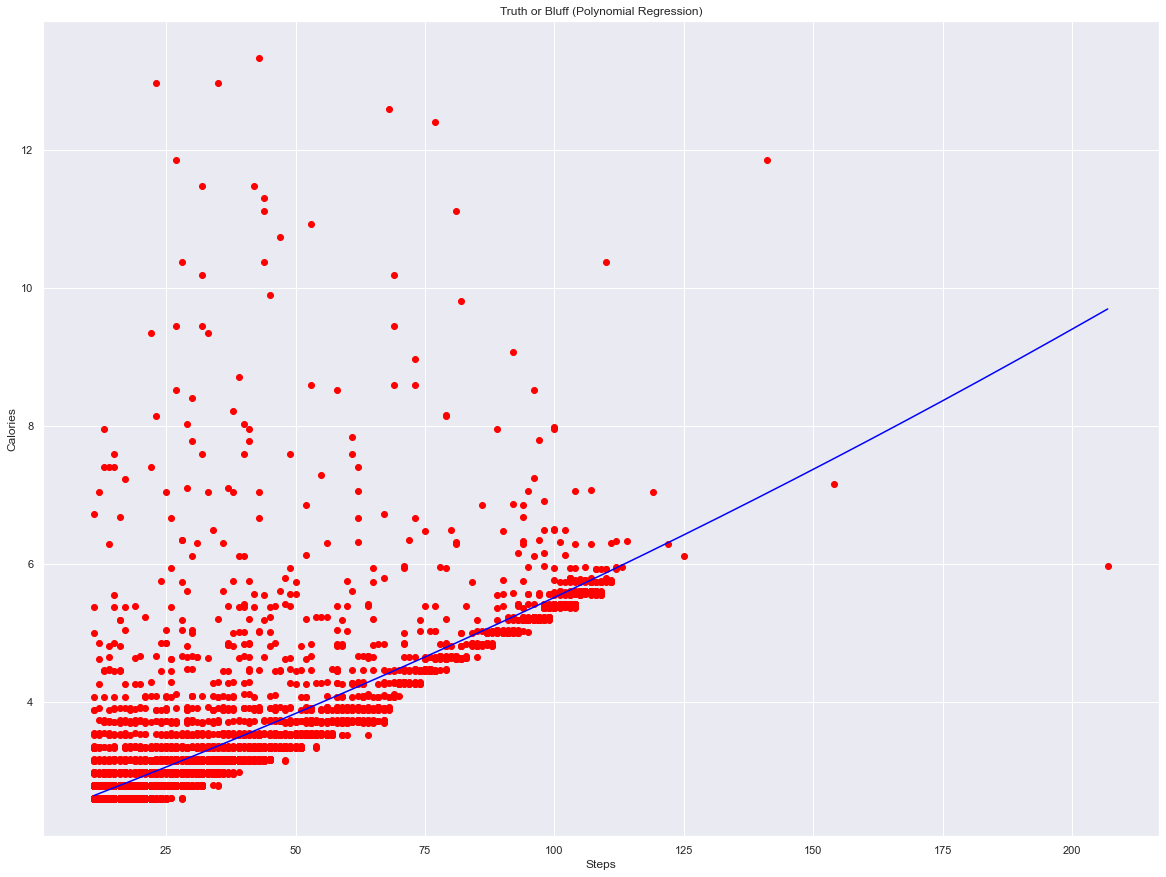

In [514]:
###
#Polynomial Regression (Calories = f(Steps))
###

#Transforming our dataset for using it in our ML:
#choosing 1 user:
dataset = by_min.loc[(by_min.Id == by_min.Id[23456])&
                    (by_min.Steps > 10)&
                    (by_min.Calories >= 2.5)]



#deleting all non_dependent variables:
dataset.drop(['Id','Date','Time'], axis=1, inplace=True)

###
#Importing the dataset
###
X = dataset.iloc[:,1:-1].values
y = dataset.iloc[:, 0].values


###
#Building and training our polynomial model (2nd degree)
###
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
            #matrix of features
            #features will be the x1^1, x1^2, x1^3, x1^(degree)                         
X_poly = poly_reg.fit_transform(X)
        #proceeds to a trasformation of a single feature (x1) to multiple features (x1, x1^2, x1^3...)
        #trasforms the object to our polynomial

        
lin_reg_2 = LinearRegression() #we need a new object of linear regression to re-train 
                               #on the new polynomial features we created
                               #building a new linear regression object tha that will be trained in the new matrix of features
lin_reg_2.fit(X_poly,y)

###
#Visualising the polynomial regression results
###

X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('Truth or Bluff (Polynomial Regression)')
plt.xlabel('Steps')
plt.ylabel('Calories')
plt.show

print('Polynomial Coefficients:')
print('y = b0 + b1*X + b2*X^2')
print('b0:',lin_reg_2.intercept_)
print ('b1:',lin_reg_2.coef_[1])
print ('b2:',lin_reg_2.coef_[2])
print ('Rsq:',r2_score(y,lin_reg_2.predict(X_poly)))

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Polynomial degree: 16
Polynomial Coefficients:
y = b0 + b1*X + b2*X^2
b0: 3.517590528597082
b1: -0.0495934862166295
b2: 0.0005354674906486168
Rsq: 0.5531196021552481


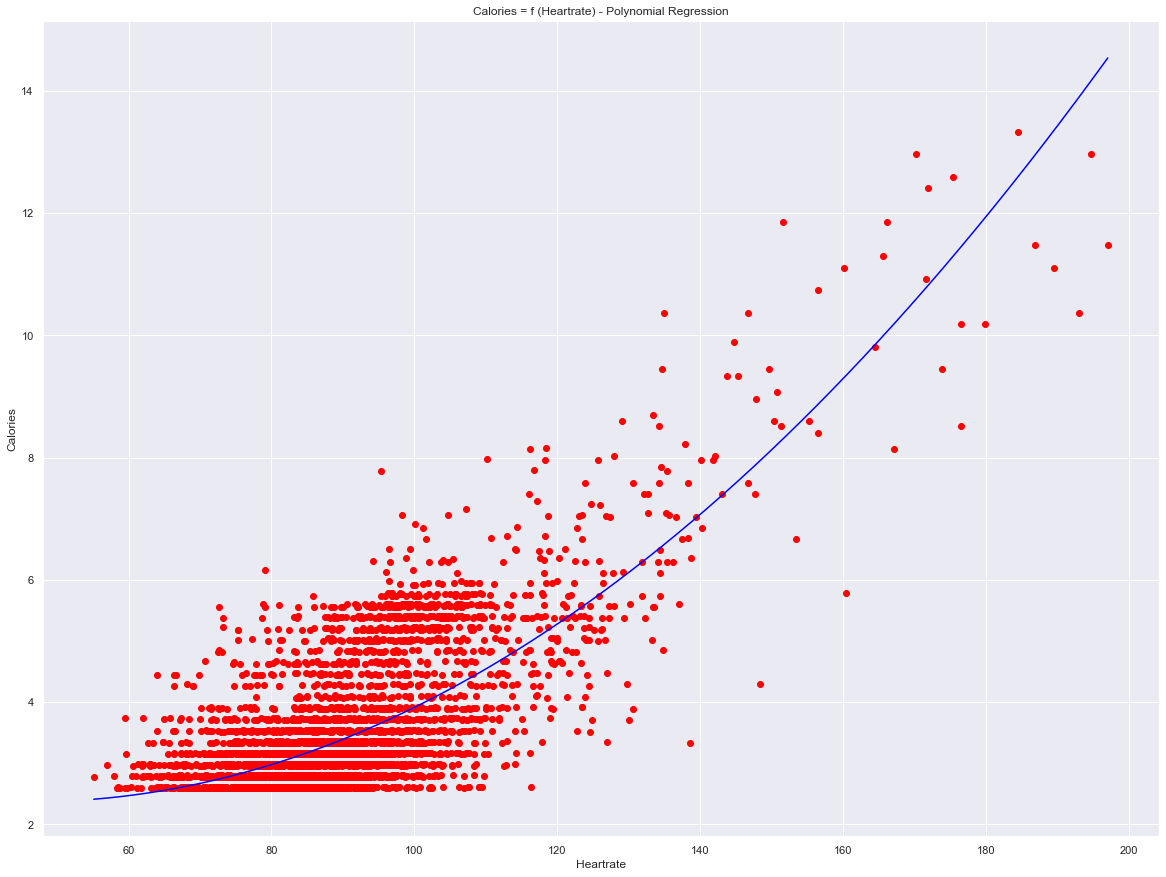

In [499]:
###
#Polynomial Regression (Calories = f(Heartrate))
###

#Transforming our dataset for using it in our ML:
#choosing 1 user:
dataset = by_min.loc[(by_min.Id == by_min.Id[23456])&
                    (by_min.Steps > 10)&
                    (by_min.Calories >= 2.5)]



#deleting all non_dependent variables:
dataset.drop(['Id','Date','Time'], axis=1, inplace=True)

###
#Importing the dataset
###
X = dataset.iloc[:,2:].values
y = dataset.iloc[:, 0].values


###
#Building and training our polynomial model (2nd degree)
###

poly_reg = PolynomialFeatures(degree = 2)
            #matrix of features
            #features will be the x1^1, x1^2, x1^3, x1^(degree)                         
X_poly = poly_reg.fit_transform(X)
        #proceeds to a trasformation of a single feature (x1) to multiple features (x1, x1^2, x1^3...)
        #trasforms the object to our polynomial

        
        

        
lin_reg_2 = LinearRegression() #we need a new object of linear regression to re-train 
                               #on the new polynomial features we created
                               #building a new linear regression object tha that will be trained in the new matrix of features
lin_reg_2.fit(X_poly,y)

###
#Visualising the polynomial regression results
###

X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.title('Calories = f (Heartrate) - Polynomial Regression')
plt.xlabel('Heartrate')
plt.ylabel('Calories')
plt.show

print ('Polynomial degree:',best_degree)
print('Polynomial Coefficients:')
print('y = b0 + b1*X + b2*X^2')
print('b0:',lin_reg_2.intercept_)
print ('b1:',lin_reg_2.coef_[1])
print ('b2:',lin_reg_2.coef_[2])
print ('Rsq:',r2_score(y,lin_reg_2.predict(X_poly)))

# Support Vector Regression (SVR)

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


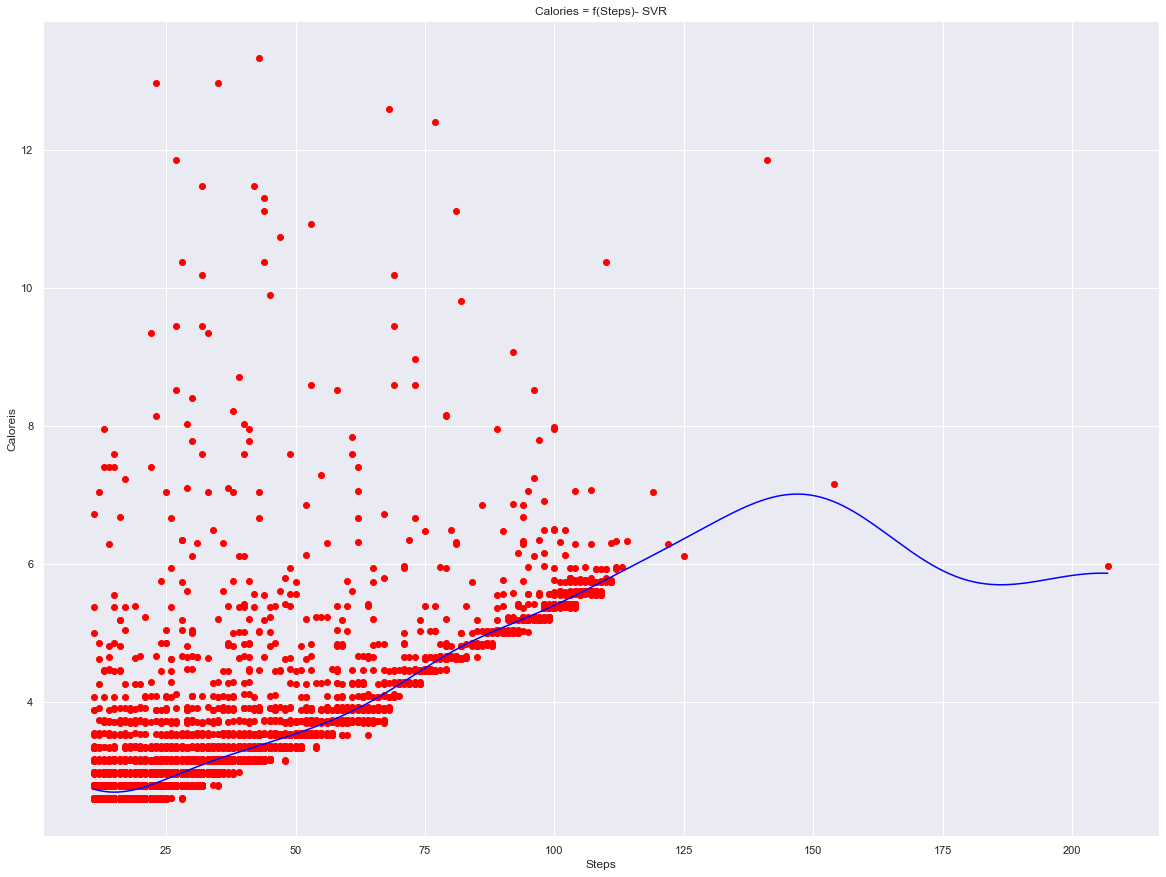

Rsq: 0.5266698712502536


In [512]:
###
#SVR regression for Calories = f(Steps)
###


#Transforming our dataset for using it in our ML:
#choosing 1 user:
dataset = by_min.loc[(by_min.Id == by_min.Id[23456])&
                    (by_min.Steps > 10)&
                    (by_min.Calories >= 2.5)]



#deleting all non_dependent variables:
dataset.drop(['Id','Date','Time'], axis=1, inplace=True)

###
#Importing the dataset
###
X = dataset.iloc[:,1:-1].values # Choosing Steps
#X = dataset.iloc[:,2:].values # Choosing Heartbeat
y = dataset.iloc[:, 0].values.reshape(-1, 1)


###
#Feature scaling
###

sc_X = StandardScaler()
sc_y = StandardScaler()
X_trns = sc_X.fit_transform(X)
y_trns = sc_y.fit_transform(y)

###
#Training the SVR model on the whole dataset
###

from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_trns, y_trns)       


###
#Predicting a new result
###
sc_y.inverse_transform(regressor.predict(sc_X.transform([[6.5]])))

###
#Predicting values for all X values
###
y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X)))


###
#Visualising the SVR results
###
X_grid = np.arange(min(sc_X.inverse_transform(X_trns)), max(sc_X.inverse_transform(X_trns)), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(sc_X.inverse_transform(X_trns), sc_y.inverse_transform(y_trns), color = 'red')
plt.plot(X_grid, sc_y.inverse_transform(regressor.predict(sc_X.transform(X_grid))), color = 'blue')
plt.title('Calories = f(Steps)- SVR')
plt.xlabel('Steps')
plt.ylabel('Caloreis')
plt.show()

print ('Rsq:',r2_score(y,y_pred))

# Building regression models for each of the users:

In [515]:
#Making a df with only unique Ids
profiles_SLR_step = pd.DataFrame(by_min.Id.unique())
profiles_SLR_step.columns =['Id']

## Using Simple Linear Regression

In [516]:
###
#SLR with Steps
###


regressor = LinearRegression()
step_slope = []
intercept = []
r2_test = []
r2_total = []


for i in by_min.Id.unique():
    #Transforming our dataset for using it in our ML:
    ###
    #choosing 1 user:
    dataset = by_min.loc[by_min.Id == i]

    #deleting all non_dependent variables:
    dataset.drop(['Id','Date','Time','Heartbeat'], axis=1, inplace=True)
     ###
    #Importing the dataset
    ###
    X = dataset.iloc[:, 1].values.reshape(-1, 1)
    y = dataset.iloc[:, 0].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    regressor.fit(X_train,y_train)
    
    ###
    #Making the Calorie prediction:
    ###
    y_pred = regressor.predict(X_test)
    y_model = regressor.predict(X)
    
    step_slope.append(regressor.coef_[0])
    intercept.append(regressor.intercept_)
    r2_test.append(r2_score(y_test,y_pred))
    r2_total.append(r2_score(y,y_model))

    

profiles_SLR_step["Step_slope"]=step_slope
profiles_SLR_step["Intercept"]=intercept
profiles_SLR_step["R2_test"]=r2_test
profiles_SLR_step["R2_total"]=r2_total

profiles_SLR_step

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWit

,Id,Step_slope,Intercept,R2_test,R2_total
0,2022484408,0.042663,2.518493,0.647759,0.669377
1,2026352035,0.016686,2.466853,0.758814,0.600666
2,2347167796,0.035057,2.122301,0.871179,0.807034
3,4020332650,0.047683,3.881585,0.663281,0.610835
4,4388161847,0.059362,2.892969,0.735712,0.708395
5,4558609924,0.032231,2.251773,0.485898,0.542987
6,5553957443,0.033708,2.005707,0.839092,0.810044
7,5577150313,0.049952,5.171531,0.260066,0.255867
8,6117666160,0.032195,2.532516,0.708812,0.670306
9,6775888955,0.041106,4.270214,0.594602,0.625043


## Using Simple Linear Regression

In [311]:
###
#SLR with Heartrate
###


#Making a df with only unique Ids
profiles_SLR_HR = pd.DataFrame(by_min.Id.unique())
profiles_SLR_HR.columns =['Id']
regressor = LinearRegression()

step_slope = []
intercept = []
r2_test = []
r2_total = []


for i in by_min.Id.unique():
    #Transforming our dataset for using it in our ML:
    ###
    #choosing 1 user:
    dataset = by_min.loc[by_min.Id == i]

    #deleting all non_dependent variables:
    dataset.drop(['Id','Date','Time','Steps'], axis=1, inplace=True)
     ###
    #Importing the dataset
    ###
    X = dataset.iloc[:, 1].values.reshape(-1, 1)
    y = dataset.iloc[:, 0].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    regressor.fit(X_train,y_train)
    
    ###
    #Making the Calorie prediction:
    ###
    y_pred = regressor.predict(X_test)
    y_model = regressor.predict(X)
    
    step_slope.append(regressor.coef_[0])
    intercept.append(regressor.intercept_)
    r2_test.append(r2_score(y_test,y_pred))
    r2_total.append(r2_score(y,y_model))

    

profiles_SLR_HR["Heart_slope"]=step_slope
profiles_SLR_HR["Intercept"]=intercept
profiles_SLR_HR["R2_test"]=r2_test
profiles_SLR_HR["R2_total"]=r2_total

profiles_SLR_HR

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWit

,Id,Heart_slope,Intercept,R2_test,R2_total
0,2022484408,0.076692,-2.492720,0.637328,0.613882
1,2026352035,0.026757,0.446401,0.291726,0.225971
2,2347167796,0.055598,-1.233562,0.495400,0.477947
3,4020332650,0.071991,-1.183410,0.316132,0.295838
4,4388161847,0.080034,-0.696779,0.481759,0.451907
5,4558609924,0.059198,-1.819181,0.548095,0.501584
6,5553957443,0.054298,-0.625110,0.462573,0.468864
7,5577150313,0.094443,-1.749125,0.501517,0.519324
8,6117666160,0.038089,-0.140900,0.285376,0.295626
9,6775888955,0.082065,-2.438443,0.321758,0.320130


## Using Multiple Linear Regression

In [518]:
###
#MLR with Steps and Heartrate
###

#Making a df with only unique Ids
UserProfile_MLR = pd.DataFrame(by_min.Id.unique())
UserProfile_MLR.columns =['Id']
regressor = LinearRegression()

hr_slope = []
step_slope = []
intercept = []
r2_test = []
r2_total = []


for i in by_min.Id.unique():
    #Transforming our dataset for using it in our ML:
    ###
    #choosing 1 user:
    dataset = by_min.loc[by_min.Id == i]

    #deleting all non_dependent variables:
    dataset.drop(['Id','Date','Time'], axis=1, inplace=True)
    
     ###
    #Importing the dataset
    ###
    X = dataset.iloc[:, 1:3].values
    y = dataset.iloc[:, 0].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    regressor.fit(X_train,y_train)
    
    ###
    #Making the Calorie prediction:
    ###
    y_pred = regressor.predict(X_test)
    y_model = regressor.predict(X)
    
    step_slope.append(regressor.coef_[0])
    hr_slope.append(regressor.coef_[1])
    intercept.append(regressor.intercept_)
    r2_test.append(r2_score(y_test,y_pred))
    r2_total.append(r2_score(y,y_model))

    
UserProfile_MLR["HR_slope"]=hr_slope
UserProfile_MLR["Step_slope"]=step_slope
UserProfile_MLR["Intercept"]=intercept
UserProfile_MLR["R2_test"]=r2_test
UserProfile_MLR["R2_total"]=r2_total

UserProfile_MLR

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWit

,Id,HR_slope,Step_slope,Intercept,R2_test,R2_total
0,2022484408,0.045721,0.029102,-1.018007,0.819284,0.822073
1,2026352035,0.018852,0.015275,0.563179,0.732965,0.667893
2,2347167796,0.021727,0.029026,0.417157,0.910070,0.853900
3,4020332650,0.046483,0.041603,-0.258939,0.763455,0.720397
4,4388161847,0.041262,0.047676,0.162265,0.819772,0.797723
5,4558609924,0.041618,0.024443,-1.155898,0.766640,0.767032
6,5553957443,0.028047,0.027704,0.031024,0.913627,0.904882
7,5577150313,0.081395,0.028618,-1.720568,0.590053,0.595896
8,6117666160,0.021758,0.028138,0.573051,0.791507,0.756069
9,6775888955,0.050062,0.035357,-0.829786,0.729044,0.736152


# Using Polynomial Regression

In [522]:
###
#Polynomial Regression (Calories = f(Steps))
###



#Making a df with only unique Ids
UserProfile_PR_step = pd.DataFrame(by_min.Id.unique())
UserProfile_PR_step.columns =['Id']
r2_total = []

for i in by_min.Id.unique():
    #Transforming our dataset for using it in our ML:
    ###
    #choosing 1 user:
    dataset = by_min.loc[by_min.Id == i]

    #deleting all non_dependent variables:
    dataset.drop(['Id','Date','Time'], axis=1, inplace=True)
    
    ###
    #Importing the dataset
    ###
    X = dataset.iloc[:, 1:-1].values #Choosing steps 
    y = dataset.iloc[:, 0].values

    ###
    #Building and training our polynomial model (2nd degree)
    ###
    poly_reg = PolynomialFeatures(degree = 2)
    X_poly = poly_reg.fit_transform(X)
    lin_reg_2 = LinearRegression() #we need a new object of linear regression to re-train 
                               #on the new polynomial features we created
                               #building a new linear regression object tha that will be trained in the new matrix of features
    lin_reg_2.fit(X_poly,y)
    rsq = r2_score(y,lin_reg_2.predict(X_poly))
    
    r2_total.append(rsq)
    
UserProfile_PR_step["R2_total"]=r2_total
UserProfile_PR_step


c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWit

,Id,R2_total
0,2022484408,0.693476
1,2026352035,0.641602
2,2347167796,0.826056
3,4020332650,0.617506
4,4388161847,0.737867
5,4558609924,0.543528
6,5553957443,0.810569
7,5577150313,0.256760
8,6117666160,0.697915
9,6775888955,0.633288


# Using Support Vector Regression

In [523]:
#Making a df with only unique Ids
UserProfile_SVR_step = pd.DataFrame(by_min.Id.unique())
UserProfile_SVR_step.columns =['Id']
r2_total = []



for i in by_min.Id.unique():
    dataset = by_min.loc[by_min.Id == i]
    dataset.drop(['Id','Date','Time'], axis=1, inplace=True)

    ###
    #Importing the dataset
    ###
    X = dataset.iloc[:,1:-1].values # Choosing Steps
    #X = dataset.iloc[:,2:].values # Choosing Heartbeat
    y = dataset.iloc[:, 0].values.reshape(-1, 1)


    ###
    #Feature scaling
    ###

    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_trns = sc_X.fit_transform(X)
    y_trns = sc_y.fit_transform(y)

    ###
    #Training the SVR model on the whole dataset
    ###
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_trns, y_trns)       

    ###
    #Predicting values for all X values
    ###
    y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X)))

    rsq = r2_score(y,y_pred)
    r2_total.append(rsq)
    
UserProfile_SVR_step["R2_total"]=r2_total

c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array wa

,Id,R2_total
0,2022484408,0.667555
1,2026352035,0.660871
2,2347167796,0.820872
3,4020332650,0.600360
4,4388161847,0.719017
5,4558609924,0.526670
6,5553957443,0.831230
7,5577150313,0.223383
8,6117666160,0.685662
9,6775888955,0.625266


# Choosing the best model for each user

In [567]:
def BestRSquare(df1,df2,descr1,descr2):
    '''
    This function takes as an input:
        - two dfs that include two columns, "Id" and "R2_total", and are of the same length
        - two strings, one_word description for each model compared
    It compares the R2_total of the two dfs, chooses the largest one, and results in a df that has 3 columns:
        - Id
        - R2_total (the maximum chosen)
        - string describing the best model
    '''
    BestModelperUser = pd.DataFrame()
    BestModelperUser['Id'] = by_min.Id.unique()
    BestModel = []
    BestRsq = []
    for i in range (len(df1)):
        if df1['R2_total'][i] > df2['R2_total'][i]:
            BestModel.append(descr1)
            BestRsq.append(df1['R2_total'][i])
        else:
            BestModel.append(descr2)
            BestRsq.append(df2['R2_total'][i])
    
    BestModelperUser['BestModel'] = BestModel
    BestModelperUser['R2_total'] = BestRsq
    
    return BestModelperUser


################################################# 


def BestRSquare_(df1,df2,descr2):
    '''
    This function takes as an input:
        - two dfs:
            df1 is the output of the BestRSquare function (with columns: 'Id','BestModel','R2_total')
            df2 that includes at least two columns "Id" and "R2_total", and are of the same length
        - one string, one_word description describing the model used for df2.
        
        It compares the R2_total of the two dfs, chooses the largest one, and results in a df that has 3 columns:
        - Id
        - R2_total (the maximum chosen)
        - string describing the best model
    '''
    BestModelperUser = pd.DataFrame()
    BestModelperUser['Id'] = by_min.Id.unique()
    BestModel = []
    BestRsq = []
    for i in range (len(df1)):
        if df1['R2_total'][i] > df2['R2_total'][i]:
            BestModel.append(df1['BestModel'][i])
            BestRsq.append(df1['R2_total'][i])
        else:
            BestModel.append(descr2)
            BestRsq.append(df2['R2_total'][i])
    
    BestModelperUser['BestModel'] = BestModel
    BestModelperUser['R2_total'] = BestRsq
    return BestModelperUser  
 
    
#################################################   

In [565]:
###
#Comparing:
# profiles_SLR_step  Vs  profiles_SLR_HR
###
BestModelperUser = BestRSquare(profiles_SLR_step,profiles_SLR_HR,'SLR_step',"SLR_HR")

###
#Comparing result of last model evaluation with:
# Multi Linear Regression  - df: UserProfile_MLR
###
BestModelperUser = BestRSquare_(BestModelperUser,UserProfile_MLR,"MultiLinearRegr")


###
#Comparing result of last model evaluation with:
# Polynomial regresion (of steps) - df: UserProfile_PR_step
###
BestModelperUser = BestRSquare_(BestModelperUser,UserProfile_PR_step,"PolyReg_Step")

###
#Comparing result of last model evaluation with:
# Support Vector regresion (of steps) - df: UserProfile_SVR_step
###
BestModelperUser = BestRSquare_(BestModelperUser,UserProfile_SVR_step,"SVR_Step")

BestModelperUser

### Conclusion: For all the users, Multi Liner Regression models fit best their data to calculate the Calories

In [568]:
###
#Total run time in min:
###
print('The total run time was:',(time.time()-t01)/60,' minutes')

The total run time was: 27499403.332079522  minutes
